In [1]:
import os
import sys
import h5py
import numpy as np
import pandas as pd
import random

import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets

from joblib import Parallel, delayed
from IPython.display import display, HTML, Video

import re
import difflib

from scipy.signal import savgol_filter

In [2]:
sys.path.append('../code/')
from data_handling import del_nan_rows, read_skeleton_as_array, calc_quality

In [3]:
path_to_skels = "/share/data/longterm/2/Jerneja_Behaviour/Tierpsy_skeleton_files_jerneja/"

In [4]:
skel_files_list = [os.path.join(root,name) for root,dirs,names in os.walk(path_to_skels) for name in names 
                   if name.endswith('skeletons.hdf5')]

## Looking at the 'quality' of the skeleton files

- How many NaN rows exist in each of the skeleton files
- Is there any bias : number of NaN rows --vs---drug type or lightOn etc..

In [5]:
def get_quality(skel_file):
    
    with h5py.File(skel_file,'r') as f:
        
        q = calc_quality(f['skeleton'])
    
    return q

In [6]:
def get_true_drug(drug):
    
    true_drug_names = ['AA', 'Dopamine','Fluoxetine','Methiothepin', 'None', 'Octopamine', 'Serotonin',
               'Tyramine', 'Alphamethyl', 'Chlorpromazine', 'Clomipramine','Imipramine',  
               'Mianserin','Paroxetine', 'Phentolamine', 'Quinpirole', 'Raclopride']
    
    
    # get only the alpha (name and not conc) part of the drug label
    drug_split = re.findall(r"[^\W\d_]+|\d+", drug)

    # find the closest match of the drug name from the list "drug_names"
    true_drug_alpha = difflib.get_close_matches(drug, true_drug_names, 
                                              n= 1, cutoff= 0.5)

    if true_drug_alpha[0] != 'Quinpirole':
        true_drug = true_drug_alpha[0]
    else:
        # replace the old spelling with the closest match 
        true_drug = drug.replace(drug_split[0],true_drug_alpha[0])

    
    return true_drug

In [7]:
def get_skel_dict(skel_file):

    
    skel_id = os.path.basename(skel_file).split('_skeletons')[0]
    
    drug = skel_id.split('_')[4]
    if drug == 'ascorbicacid':
        drug = 'AA'
        
        
    try:
        drug = get_true_drug(drug)
    except IndexError:
        print(f"Error thrown for:{drug}")
        
        
    with h5py.File(skel_file,'r') as f:
        skel_quality = calc_quality(f['skeleton'])
        skel_lengths = np.array(f['skeleton_length'])
         
    return {'id':skel_id,'drug':drug, 'quality':skel_quality}

In [8]:
skel_list  = Parallel(n_jobs=10, verbose = 5)(delayed(get_skel_dict)(skel_file) for skel_file in skel_files_list)

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:    7.8s
[Parallel(n_jobs=10)]: Done 142 tasks      | elapsed:   11.5s
[Parallel(n_jobs=10)]: Done 268 tasks      | elapsed:   17.7s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:   30.9s
[Parallel(n_jobs=10)]: Done 628 tasks      | elapsed:   43.9s
[Parallel(n_jobs=10)]: Done 862 tasks      | elapsed:   57.5s
[Parallel(n_jobs=10)]: Done 1132 tasks      | elapsed:  1.2min
[Parallel(n_jobs=10)]: Done 1438 tasks      | elapsed:  1.5min
[Parallel(n_jobs=10)]: Done 1780 tasks      | elapsed:  1.8min
[Parallel(n_jobs=10)]: Done 2158 tasks      | elapsed:  2.1min
[Parallel(n_jobs=10)]: Done 2572 tasks      | elapsed:  2.4min
[Parallel(n_jobs=10)]: Done 3022 tasks      | elapsed:  2.8min
[Parallel(n_jobs=10)]: Done 3508 tasks      | elapsed:  3.3min
[Parallel(n_jobs=10)]: Done 4030 tasks      | elapsed:  3.7min
[Parallel(n_jobs=10)]: Done 4286 out of 4286 | 

In [10]:
df_skel_data = pd.DataFrame(skel_list)

In [11]:
np.unique(df_skel_data['drug'])

array(['AA', 'Alphamethyl', 'Chlorpromazine', 'Clomipramine', 'Dopamine',
       'Fluoxetine', 'Imipramine', 'Methiothepin', 'Mianserin', 'None',
       'Octopamine', 'Paroxetine', 'Phentolamine', 'Quinpirole0003',
       'Quinpirole003', 'Raclopride', 'Serotonin', 'Tyramine'],
      dtype=object)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f98a5b145c0>,
      dtype=object)

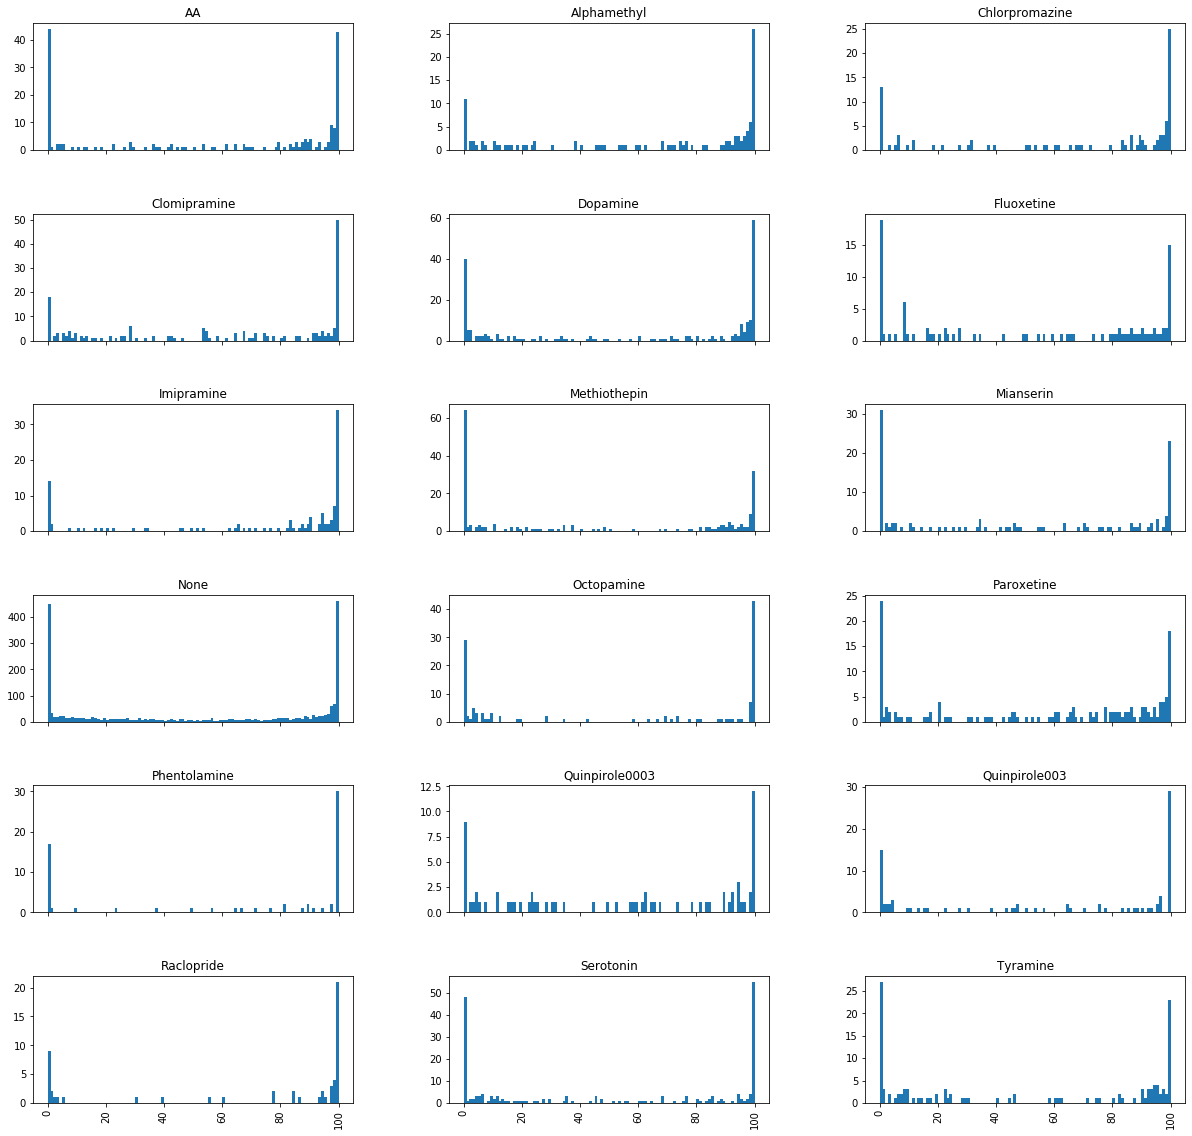

In [12]:
fig, axes = plt.subplots(6,3,figsize=(20,20), sharex=True)
df_skel_data.hist(by='drug',bins=100, ax= axes)

## Skeleton lengths 

In [13]:
n_files = 1
skel_file = random.sample(skel_files_list, n_files)
skel_file

['/share/data/longterm/2/Jerneja_Behaviour/Tierpsy_skeleton_files_jerneja/20181128/Results/avis/20181128_142141_1_5m0s_None_None_Light_INVERTED_skeletons.hdf5']

In [55]:
test_data= h5py.File(skel_file[0],'r')

In [56]:
skel_data = test_data['skeleton']
q = calc_quality(skel_data)
print(skel_data.shape, q)

(53, 49, 2) 100.0


In [57]:
cont_widths = test_data['contour_width']
cont_widths.shape

(53, 49)

In [58]:
cont_coords1 = test_data['contour_side1']
cont_coords2 = test_data['contour_side2']

In [68]:
slider_frame = widgets.IntSlider(value= 0,
                                        min=0,
                                        max= len(test_data['skeleton_length'])-1,
                                        step=1,
                                        description='Frames:',
                                        disabled=False,
                                        continuous_update=False,
                                        orientation='horizontal',
                                        readout=True,
                                        readout_format='d')


@widgets.interact
def plot_skeleton_with_contour(ind_frame = slider_frame):
    
    fig, axes = plt.subplots(3,1,figsize=(10,15))
    
    axes[0].scatter(skel_data[ind_frame,:,0],skel_data[ind_frame,:,1])
    
    axes[0].scatter(skel_data[ind_frame,0,0],skel_data[ind_frame,0,1],c='r')
    axes[0].scatter(skel_data[ind_frame,20,0],skel_data[ind_frame,20,1],c='r')
    axes[0].set_aspect('equal')
    axes[0].autoscale(True)
    
    filt_skel_data = savgol_filter(skel_data[ind_frame,:,:].reshape(1,-1,2),
                                    window_length=15,polyorder=2,mode='nearest', axis=1)
    
    axes[1].scatter(filt_skel_data[0,:,0],filt_skel_data[0,:,1])
    axes[1].set_aspect('equal')
    
    axes[2].plot(test_data['skeleton_length'])
    axes[2].axvline(x=ind_frame, c='k')


interactive(children=(IntSlider(value=0, continuous_update=False, description='Frames:', max=52), Output()), _…

## Neck point calculation

In [69]:
# Jerneja's calculation : neck_point

def get_neckpoint(cont_widths):
    
    
    print(np.shape(cont_widths),np.shape(np.diff(cont_widths)))
    diff_contour = np.nanmean(np.diff(cont_widths), axis=0)
    print(diff_contour.shape)
    diff_contour = diff_contour[3:26]
    neck_point = np.argmin(diff_contour)+4
    
    return neck_point

In [84]:
slider_frame = widgets.IntSlider(value= 0,
                                        min=0,
                                        max= len(test_data['skeleton_length']),
                                        step=1,
                                        description='Frames:',
                                        disabled=False,
                                        continuous_update=False,
                                        orientation='horizontal',
                                        readout=True,
                                        readout_format='d')


@widgets.interact
def plot_skeleton_with_contour(ind_frame = slider_frame):
    
    fig, axes = plt.subplots(2,1,figsize=(10,15))
    
    axes[0].plot(skel_data[ind_frame,:,0],skel_data[ind_frame,:,1])
    axes[0].plot(cont_coords1[ind_frame,:,0],cont_coords1[ind_frame,:,1])
    axes[0].plot(cont_coords2[ind_frame,:,0],cont_coords2[ind_frame,:,1])
    axes[0].set_aspect('equal')
    axes[0].autoscale(True)
    
    neck_pt = get_neckpoint(cont_widths)
    print(neck_pt)
    axes[0].scatter(skel_data[ind_frame,neck_pt,0],skel_data[ind_frame,neck_pt,1],c='r')
    axes[0].scatter(cont_coords1[ind_frame,neck_pt,0],cont_coords1[ind_frame,neck_pt,1],c='r')
    axes[0].scatter(cont_coords2[ind_frame,neck_pt,0],cont_coords2[ind_frame,neck_pt,1],c='r')
    
    axes[0].scatter(skel_data[ind_frame,20,0],skel_data[ind_frame,20,1],c='k')
    axes[0].scatter(cont_coords1[ind_frame,20,0],cont_coords1[ind_frame,20,1],c='k')
    axes[0].scatter(cont_coords2[ind_frame,20,0],cont_coords2[ind_frame,20,1],c='k')
    
    axes[0].fill(cont_coords1[ind_frame,0:neck_pt,0],
                         cont_coords1[ind_frame,0:neck_pt,1],
                         cont_coords2[ind_frame,0:neck_pt,0],
                         cont_coords2[ind_frame,0:neck_pt,1])
    
    axes[1].plot(test_data['skeleton_length'])
    axes[1].axvline(x=ind_frame, c='k')


interactive(children=(IntSlider(value=0, continuous_update=False, description='Frames:', max=53), Output()), _…

In [88]:
!jupyter --version

jupyter core     : 4.6.2
jupyter-notebook : 6.0.3
qtconsole        : 4.6.0
ipython          : 7.12.0
ipykernel        : 5.1.4
jupyter client   : 5.3.4
jupyter lab      : 1.2.6
nbconvert        : 5.6.1
ipywidgets       : 7.5.1
nbformat         : 5.0.4
traitlets        : 4.3.3


In [96]:
video_file_path = '/share/data/longterm/2/Jerneja_Behaviour/Tierpsy_skeleton_files_jerneja/20180926/redo/20180926_144454_1_5m0s_AA_None_None_INVERTED.avi'

In [95]:
vid = widgets.Video.from_file(video_file_path)
display(vid)

Video(value=b'RIFF\x90\xdb\xae0AVI LIST\xec\x11\x00\x00hdrlavih8\x00\x00\x005\x82\x00\x00\x00\x00\x96\x00\x00\…

In [98]:
Video(video_file_path)

In [38]:
8397/300

27.99

# Neck point calculation

In [ ]:
f = h5py.file(filename, 'a')


In [ ]:
file_path = "/data/longterm/10/Marios Tierpsy Analysis/29042020_90fps/RawVideos/Results/"